In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


### Train Data exploration and visualization

In [2]:
df_train = pd.read_csv('train.csv')
qids = pd.Series(df_train['qid1'].tolist()+df_train['qid2'].tolist())

In [3]:
qids.value_counts() # Question Number of times repeated

2559      157
30782     120
4044      111
2561       88
14376      79
17978      77
2675       68
28764      66
1772       63
24555      61
18753      58
4018       57
28133      56
3595       55
19621      55
18531      55
4951       55
13748      54
10024      54
10330      54
38         54
18296      53
11264      52
6551       52
20190      52
691        51
8461       51
6749       51
2322       51
33412      51
         ... 
95599       1
87403       1
259391      1
89450       1
1345        1
7490        1
13639       1
19784       1
17737       1
23882       1
32078       1
30031       1
34129       1
40274       1
38227       1
42325       1
48470       1
56666       1
54619       1
60764       1
64862       1
62815       1
66913       1
73058       1
77156       1
75109       1
81254       1
85352       1
83305       1
168274      1
Length: 537933, dtype: int64

In [4]:
unique_qid = set(qids)
unique_qsts = len(unique_qid)
qs_morethan_onetime= sum(qids.value_counts()>1)
qs_morethan_onetime

111780

In [5]:
  df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
#check how many questions with any null value
nan_count = df_train[df_train.isnull().any(1)]
nan_count

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [7]:
df_train[df_train.isnull().any(1)]
df_train = df_train.fillna('') #Fill null values with '' string

In [8]:
#Re-check how many questions with any null value
nan_count = df_train[df_train.isnull().any(1)]
nan_count #Finally the we found the question with no null values 

,id,qid1,qid2,question1,question2,is_duplicate


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404290 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [10]:
df_train.groupby("is_duplicate")['id'].count() #count the number of 'duplicate' and 'non-duplicate' question

is_duplicate
0    255027
1    149263
Name: id, dtype: int64

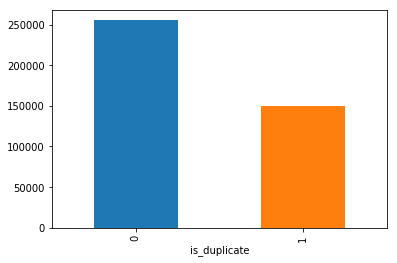

In [11]:
df_train.groupby("is_duplicate")['id'].count().plot.bar() #plot the graph for the above data

In [12]:
is_duplicate0 = len(df_train[df_train['is_duplicate']==0])
is_duplicate0/len(df_train)
print("Percentage of non-Duplicate Questions: %d percentage"%((is_duplicate0/len(df_train))*100))

Percentage of non-Duplicate Questions: 63 percentage


In [13]:
is_duplicate1 = len(df_train[df_train['is_duplicate']==1])
is_duplicate1/len(df_train)

print("Percentage of Duplicate Questions: %d percentage"%((is_duplicate1/len(df_train))*100))

Percentage of Duplicate Questions: 36 percentage


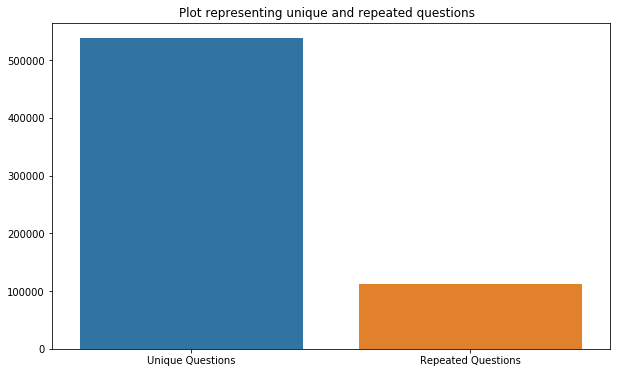

In [14]:
x = ["Unique Questions" , "Repeated Questions"]
y =  [unique_qsts , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [15]:
#Check whether there are any repeated pair of questions
pair_duplicates  = df_train[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print('Total Number of pair_duplicates groups: ',pair_duplicates.shape[0])
print('Total Number of row: ',df_train.shape[0]) #If both count are equal then there are no duplicates
print("Total duplicate pairs: ",(df_train.shape[0] - pair_duplicates.shape[0]))

Total Number of pair_duplicates groups:  404290
Total Number of row:  404290
Total duplicate pairs:  0


### Overall info about train Data

In [17]:
df_test = pd.read_csv('test.csv')

In [ ]:
print('Total number of question pairs in training dataset: ', len(df_train))
print('total number of question pairs to predict is_duplicate: ', len(df_test))
print('Total number of unique questions in training dataset: ', len(unique_qid))
print("In Train dataset: ")
print('Total percentage of is_duplicate=0: ', round((is_duplicate0/(is_duplicate0+is_duplicate1))*100, 2), "%")
print('Total percentage of is_duplicate=1: ', round((is_duplicate1/(is_duplicate0+is_duplicate1))*100, 2), "%")

Total number of question pairs in training dataset:  404290
total number of question pairs to predict is_duplicate:  2345796
Total number of unique questions in training dataset:  537933
In Train dataset: 
Total percentage of is_duplicate=0:  63.08 %
Total percentage of is_duplicate=1:  36.92 %


###  Feature extraction 

1. **q1_len** = Length of Question-1
2. **q2_len** = Length of Question-2
3. **q1_no_words** = Number of words in Question-1
4. **q2_no_words** = Number of words in Question-2
5. **total_uni_words** = Total number of unique words in Question-1 and Question-2, Combine and find unique.
6. **common_words** = Total number of common words in both Question-1 and Question-2
7. **word_share** = Total number of words share(common_words/total_words)
8. **total_words** = Total number of words unique words in Question-1 and Question-2, find Unique in each and add them.

In [21]:
# def total_uni_words(row):
# #     print(row['question1'])
# df_train['total_uni_words'] = df_train.apply(total_uni_words, axis=1)

In [38]:
df_train['q1_len'] = df_train['question1'].str.len()
df_train['q2_len'] = df_train['question2'].str.len()
df_train['q1_no_words'] = df_train['question1'].apply(lambda x: len(x.split()))
df_train['q2_no_words'] = df_train['question2'].apply(lambda x: len(x.split()))
def total_uni_words(row):
    q1_w = row['question1'].lower().strip().split()
    q2_w = row['question2'].lower().strip().split()
    total_w = len(set(q1_w + q2_w))
    return total_w
df_train['total_uni_words'] = df_train.apply(total_uni_words, axis=1)
def total_words(row):
    q1_w = set(row['question1'].lower().strip().split())
    q2_w = set(row['question2'].lower().strip().split())
    total_w = len(q1_w)+ len(q2_w)
    return total_w

df_train['total_words'] = df_train.apply(total_words, axis=1)

def common_words(row):
    q1_w = set(row['question1'].lower().strip().split())
    q2_w = set(row['question2'].lower().strip().split())
    common_w = len(q1_w.intersection(q2_w)) #find common between two sets
#     x = set(["a","b","c","d"])
#     y = set(["c","d", 'f'])
#     print( y.intersection(x) )
#     outPut: {'c', 'd'}
    return common_w
df_train['common_words'] = df_train.apply(common_words, axis=1)   
def word_share(row):
    w_share = row['common_words']/row['total_words']
    return 1.0*w_share
    
df_train['word_share'] = df_train.apply(word_share, axis=1)   
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,total_uni_words,q1_len,q2_len,q1_no_words,q2_no_words,total_words,common_words,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,13,66,57,14,12,23,10,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,16,51,88,8,13,20,4,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,20,73,59,14,10,24,4,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,19,50,65,11,9,19,0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,18,76,39,13,7,20,2,0.100000


\\cifs-ecs.cs.odu.edu\Grad\cmuthyal\win_user_profile\AppData\Python\Python36\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


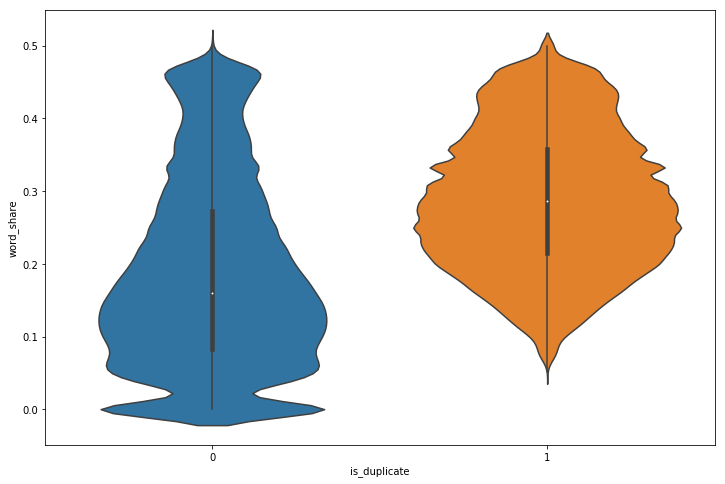

In [67]:
plt.figure(figsize=(12, 8))

sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df_train)

In [ ]:
plt.figure(figsize=(12, 8))

sns.violinplot(x = 'is_duplicate', y = 'common_words', data = df_train)

\\cifs-ecs.cs.odu.edu\Grad\cmuthyal\win_user_profile\AppData\Python\Python36\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


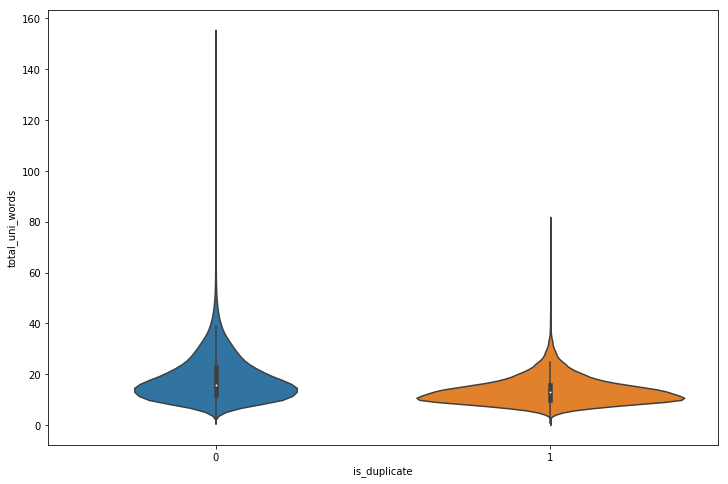

In [68]:
plt.figure(figsize=(12, 8))

sns.violinplot(x = 'is_duplicate', y = 'total_uni_words', data = df_train)

In [58]:
#Some Analysis of extracted feature

print("Shortest length of the question in Question-1: %d"%min(df_train['q1_no_words']))
print("Shortest length of the question in Question-2:  %d"%min(df_train['q2_no_words']))

Shortest length of the question in Question-1: 1
Shortest length of the question in Question-2:  1


In [59]:
df_train = df_train[df_train['q1_no_words']>0]
df_train = df_train[df_train['q2_no_words']>0]
print("Shortest length of the question in Question-1: %d"%min(df_train['q1_no_words']))
print("Shortest length of the question in Question-2:  %d"%min(df_train['q2_no_words']))

Shortest length of the question in Question-1: 1
Shortest length of the question in Question-2:  1


In [60]:
# Now find how many number of questions with min length
print("Total number of question with min length in Question-1: ",df_train[df_train['q1_no_words']==1].shape[0])
print("Total number of question with min length in Question-2: ",df_train[df_train['q2_no_words']==1].shape[0])

Total number of question with min length in Question-1:  69
Total number of question with min length in Question-2:  25
